## FxLMS Algorithm for Active Noise Control (ANC) 

### This script implements the filtered reference least mean squares (FxLMS) algorithm in a feedforward-active noise control (FF-ANC) system. You may click "Runtime > Run all" (if you use Colab) or click the "Run All" button (if you use Visual Studio Code) to run all cells in one operation.

## Notations

1. The entire reference signal: $\mathbf{x}(n) = \left[ x(n) \ x(n-1)\ \ldots x(n-N+1) \right]^T$ with $N$ samples, where $T$ is the transpose operator.  
2. Control filter coefficients: $\mathbf{w}(n) = \left[ w_0(n) \ w_1(n)\ \ldots w_{L-1}(n) \right]^T$, where $L$ denotes the length of control filter.  
3. The reference signal input to one tap of the control filter: $\mathbf{x}_L(n) = \left[ x(n) \ x(n-1)\ \ldots x(n-L+1) \right]^T$ with the most recent $L$ samples.    
4. Impulse response of the primary path: $p(n)$.  
5. Impulse response of the secondary path: $s(n)$.  
6. Disturbance: $d(n) = x(n) * p(n)$, where $*$ denotes the linear convolution operator.  
7. Filtered reference signal: $x'(n) = x(n) * \hat{s}(n)$, where $\hat{s}(n)$ denotes the estimate of $s(n)$. For simplicity, we assume $\hat{s}(n) = s(n)$.  
8. Control filter output: $y(n) = \mathbf{w}^T(n)\mathbf{x}_L(n)$.
9. Anti-noise: $y'(n) = s(n) * y(n) = s(n) * [\mathbf{w}^T(n)\mathbf{x}_L(n)] = \mathbf{w}^T(n)\mathbf{x}'(n)$, where $\mathbf{x}'(n) = \left[ x'(n) \ x'(n-1)\ \ldots x'(n-L+1) \right]^T$ with $L$ samples.  
10. Error signal: $e(n) = d(n) - y'(n)$.  
11. FxLMS coefficients update: $\mathbf{w}(n+1) = \mathbf{w}(n) + \mu \mathbf{x}'(n) e(n)$, where $\mu$ is the step size.
12. Noise reduction level (NRL): $\mathrm{NRL} = 10 \log_{10} \left(\frac{\text{Power}_d}{\text{Power}_e}\right)$, where $\text{Power}_d$ is the power of the disturbance, and $\text{Power}_e$ is the power of the error (residual noise) signal.

## Procedures

#### 1. Review the Codes: 
Read the codes in this .ipynb file to understand how the FxLMS algorithm works.
#### 2. Load a Different Audio File:
Two audio files are provided in the "ANC Audio Files" folder. The current script uses "Mix_Aircraft_Traffic.wav". Replace it with "Connect_Aircraft_Traffic.wav", and use this file for all the experiments in the following steps.
#### 3. Vary the Control Filter Length $L$：
Set the step size $\mu = 0.001$ and try at least 3 different values of the control filter length $L$. For each case, plot the time history figure separately, and plot the noise reduction level curves together in a single combined figure.
#### 4. Vary the Step Size $\mu$：
Set the control filter length $L = 1024$, and try at least 3 different values of the step size $\mu$. For each case, plot the time history figure separately, and plot the noise reduction level curves together in a single combined figure.
#### 5. Implement the FxNLMS Algorithm:
The FxLMS algorithm updates the coefficients using $\mathbf{w}(n+1) = \mathbf{w}(n) + \mu \mathbf{x}'(n) e(n)$. Nevertheless, the filtered reference normalized least mean squares (FxNLMS) method updates the coefficients based on $\mathbf{w}(n+1) = \mathbf{w}(n) + \frac{\mu}{\mathbf{x}'(n)^T \mathbf{x}'(n) + \delta} \mathbf{x}'(n) e(n)$, where $\delta$ is a small positive constant to avoid division by zero, typically set to $10^{-6}$ or $10^{-8}$. According to this script, please implement the FxNLMS algorithm and set $L$ to 1024, then test at least 3 different values of $\mu$. For each case, plot the time history figure separately, and plot the noise reduction level curves together in a single combined figure. 

## Answer the following questions

1. This script implements a feedforward ANC system. Please describe the advantages of the feedforward ANC over feedback ANC.
2. Analyze the effect of the control filter length $L$ on the performance of the FxLMS algorithm.
3. Analyze the effect of the step size $\mu$ on the performance of the FxLMS algorithm.
4. Analyze the effect of the step size $\mu$ on the performance of the FxNLMS algorithm.
5. Compare the FxLMS and FxNLMS algorithms and discuss their respective advantages and disadvantages.

In [1]:
import numpy as np
import scipy.io
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

In [2]:
# Load primary and secondary paths
mat_p = scipy.io.loadmat('Primary_and_secondary_paths/Primary_path.mat')    # Primary path
mat_s = scipy.io.loadmat('Primary_and_secondary_paths/Secondary_path.mat')  # Secondary path
# Flatten to 1D array
Pz1 = mat_p['Pz1'].flatten() # Impulse response of primary path: p(n)
S = mat_s['S'].flatten() # Impulse response of secondary path: s(n)

In [3]:
# Load the audio 
original_audio, original_sampling_rate = sf.read('ANC_audio_files/Mix_Aircraft_Traffic.wav')
sampling_rate = 16000 # Set the sampling rate to 16000Hz
# Reference signal 
x = librosa.resample(original_audio, orig_sr=original_sampling_rate, target_sr=sampling_rate) 
N = len(x) # Length of the entire reference signal
duration = N / sampling_rate # Seconds
t = np.linspace(0, duration, N) # Time index

In [4]:
# Function of generating the disturbance and filtered reference
def disturbance_and_fx_generation(primary_path, secondary_path, reference_signal, L):
    # Compute the disturbance 
    Disturbance = lfilter(primary_path, [1], reference_signal) 
    # Compute the filtered reference 
    fx = lfilter(secondary_path, [1], reference_signal)
    # Zero-padding the filtered reference at the beginning to handle the control filter delay
    fx = np.concatenate((np.zeros(L - 1), fx))
    return Disturbance, fx

# Function of the FxLMS algorithm
def FxLMS(mu, L): # mu: step size; L: control filter length
    w = np.zeros(L)      # Initialize adaptive filter coefficients
    error = np.zeros(N)  # Initialize error signal array

    # FxLMS algorithm main loop
    for n in range(N):
        fx_vec = fx[n : n + L][::-1]  # Filtered reference with the most recent L samples
        y = np.dot(w, fx_vec)          # Anti-noise
        error[n] = Disturbance[n] - y           # Residual error signal
        w += mu * error[n] * fx_vec   # Coefficients update
    return error

# Function of calculating average noise reduction level (dB) per second
def Calculate_NRL(Disturbance, error, sampling_rate, duration, N):
    samples_per_second = sampling_rate
    num_seconds = int(np.ceil(duration))
    noise_reduction_db = np.zeros(num_seconds)

    for second in range(num_seconds):
        start_idx = second * samples_per_second
        end_idx = (second + 1) * samples_per_second
        if end_idx > N:
            end_idx = N
    
        # Calculate power of disturbance and error signal
        power_d = np.mean(Disturbance[start_idx:end_idx]**2)
        power_e = np.mean(error[start_idx:end_idx]**2)
    
        # Calculate the noise reduction level (NRL): NRL = 10*log10(power_d / power_e)
        if power_d > 0 and power_e > 0: # Avoid division by zero
            noise_reduction_db[second] = 10 * np.log10(power_d / power_e)
        else:
            noise_reduction_db[second] = 0

    # Create time points for step plot
    time_points = np.arange(num_seconds + 1)  # 0, 1, 2, ..., num_seconds
    # Extend the last value to make the step plot complete
    noise_reduction_db_extended = np.append(noise_reduction_db, noise_reduction_db[-1])
    return noise_reduction_db_extended, time_points

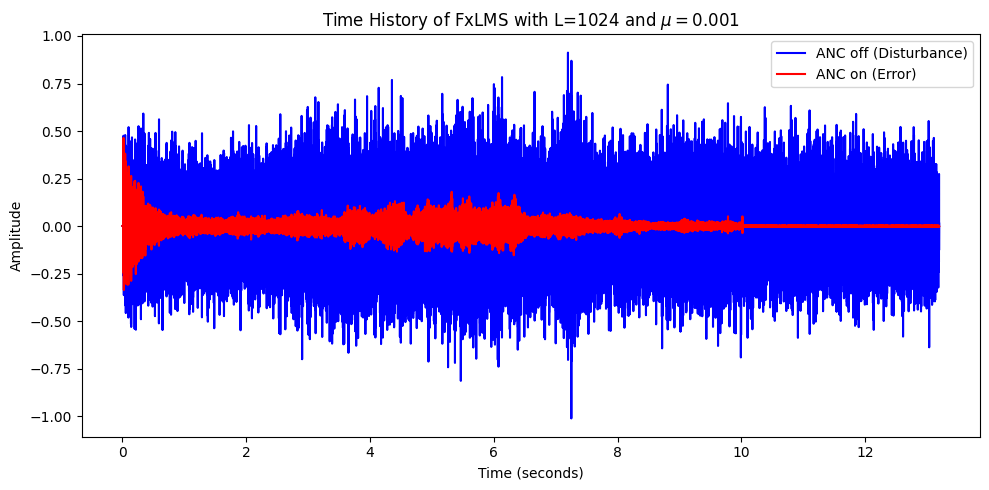

In [5]:
# Test
L = 1024     # Control filter length
mu = 0.001   # Step size
# Generation of the disturbance and filtered reference
Disturbance, fx = disturbance_and_fx_generation(Pz1, S, x, L)
# Run the FxLMS algorithm 
error = FxLMS(mu, L)

# Plot the time history figure 
plt.figure(figsize=(10, 5))
plt.plot(t, Disturbance, 'b', label='ANC off (Disturbance)')
plt.plot(t, error, 'r', label='ANC on (Error)')
plt.title(r'Time History of FxLMS with L=1024 and $\mu=0.001$')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

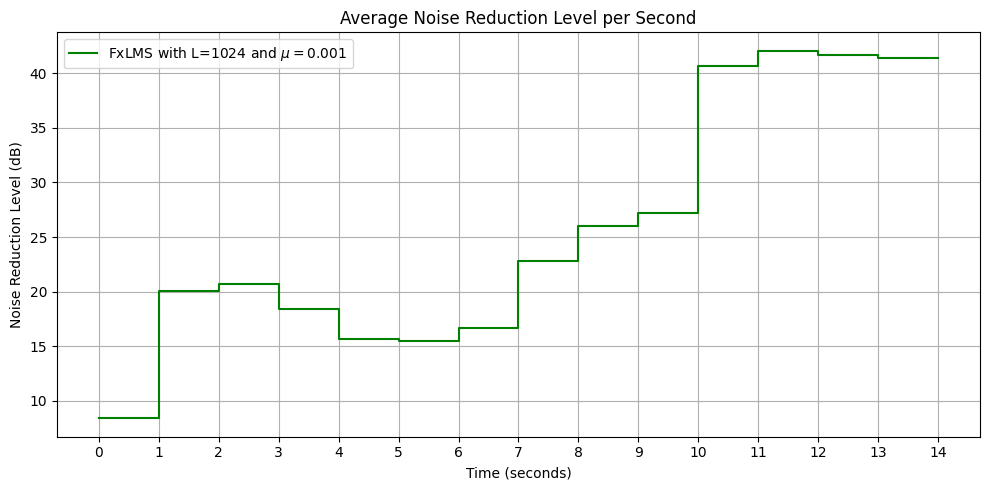

In [6]:
# Calculate the NRL
noise_reduction_db_extended, time_points = Calculate_NRL(Disturbance, error, sampling_rate, duration, N)

# Plot the noise reduction level curve
plt.figure(figsize=(10, 5))
plt.step(time_points, noise_reduction_db_extended, 'g', where='post', label=r'FxLMS with L=1024 and $\mu=0.001$')
plt.title('Average Noise Reduction Level per Second')
plt.xlabel('Time (seconds)')
plt.ylabel('Noise Reduction Level (dB)')
plt.xticks(time_points)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()